[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fonnesbeck/bayes_course_june_2024/blob/master/notebooks/Section2_3-Generalized_Linear_Models.ipynb)

# Bayesian GLM

In the previous section, the final example involved a Poisson regression model because the outcome was a count variable. In this section, we will expand on this type of application using Generalized Linear Models (GLMs), which are a generalization of linear regression that allows for non-normal distributions of the outcome variable.

We'll also show you a common circumstance where the assumptions built into these distributions fall apart in real life, and how to address the problem.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import xarray as xr
from matplotlib.lines import Line2D

RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Poisson regression: Unbounded count data

This model is inspired by [a project by Ian Osvald](http://ianozsvald.com/2016/05/07/statistically-solving-sneezes-and-sniffles-a-work-in-progress-report-at-pydatalondon-2016/), which is concerned with understanding the various effects of external environmental factors upon the allergic sneezing of a test subject.

We're going to work with simpler data than the original study, which will allow you to clearly see the modeling stakes.

In [2]:
sneezes = pd.read_csv("../data/poisson_sneeze.csv")
sneezes

,nsneeze,alcohol,meds
0,2,0,1
1,2,0,1
2,0,0,1
3,1,0,1
4,3,0,1
...,...,...,...
3995,27,1,0
3996,33,1,0
3997,35,1,0
3998,12,1,0


+ The subject sneezes N times per day, recorded as `nsneeze (int)`. The data are aggregated per day, to yield a total count of sneezes on that day.
+ The subject may or may not drink alcohol during that day, recorded as `alcohol (boolean)`
+ The subject may or may not take an antihistamine medication during that day, recorded as `meds (boolean)`

We assume that sneezing occurs at some baseline rate, which increases if an antihistamine is not taken, and further increases if alcohol is consumed.

### Visualize the data and set up the model

/Users/afengler/miniconda3/envs/iqvia_workshop/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/afengler/miniconda3/envs/iqvia_workshop/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


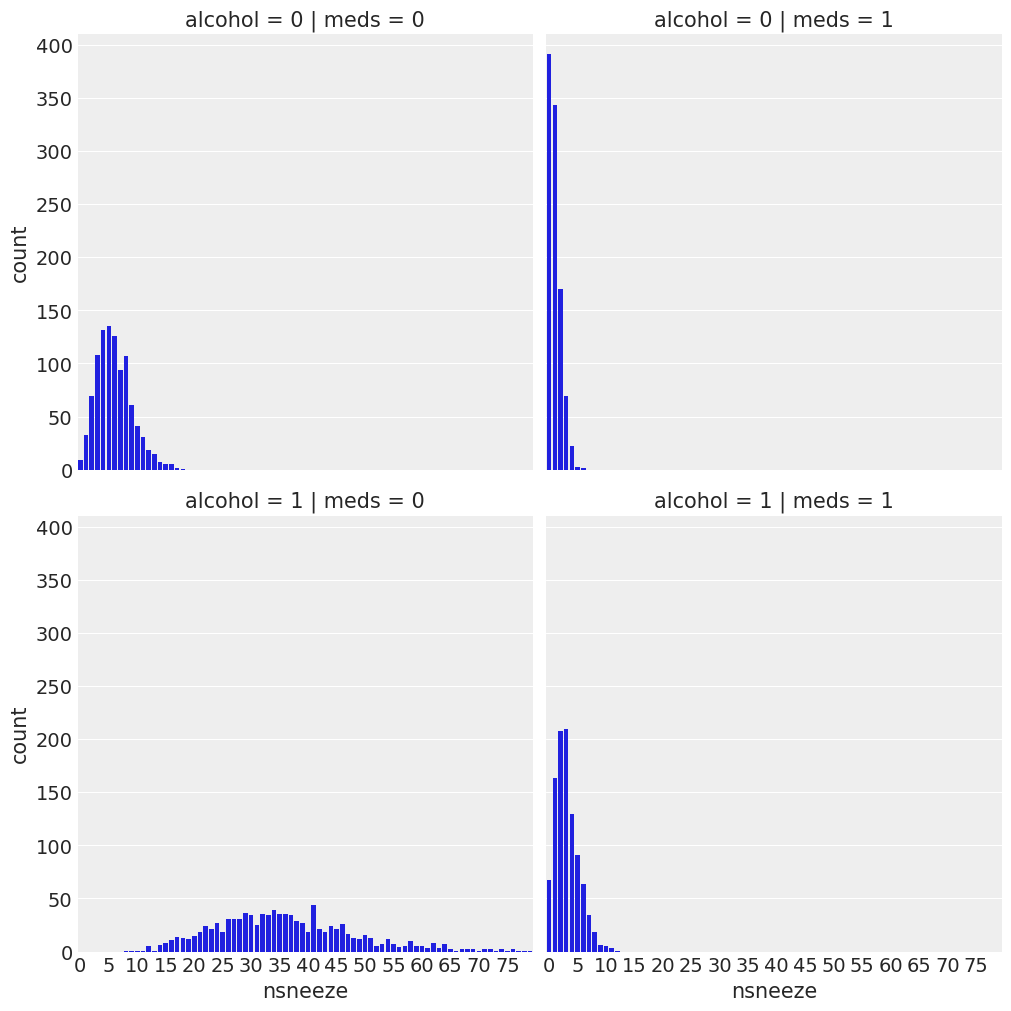

In [4]:
g = sns.catplot(
    x="nsneeze", col="meds", row="alcohol", data=sneezes, kind="count", color="blue"
)

# Make x-axis ticklabels less crowded
ax = g.axes[1, 0]
labels = range(len(ax.get_xticklabels(which="both")))
ax.set_xticks(labels[::5])
ax.set_xticklabels(labels[::5]);


The usual way of thinking about data coming from a Poisson distribution is as number of occurences of an event in a *given timeframe*. Here *number of sneezes per day*. The intensity parameter $\lambda$ specifies how many occurences we expect.

A nice property of the Poisson is that it's defined with only one parameter $\lambda$, which describes both the mean and variance of the Poisson, can be interpreted as the rate of events per unit -- here, if we inferred $\lambda = 2.8$, that would mean the subject is thought to sneeze about 2.8 times per day (implying in addition a $2.8$ variance).

In statistical terms, that means our likelihood is 

$$ Y_{\text{sneeze}} \sim \mathrm{Poisson}(\lambda)$$

Now, we need a prior on $\lambda$ ...

This is where the regression component comes in: remember that we want to infer the effect of meds and alcohol on the number of sneezes. So, we can use the usual linear regression formula we are familiar with: 

$$\lambda = \alpha + \beta_{\text{meds}} * \text{meds} + \beta_{\text{alcohol}} * \text{alcohol}$$

We will specify **weakly-informative priors** on the model latent variables.

$$
\begin{aligned}
\alpha &\sim \mathrm{Normal}(0, 5)\\
\beta_{\text{meds}}, \beta_{\text{alcohol}} &\sim \mathrm{Normal}(0, 1)\\
\lambda &= \alpha + \beta_{\text{meds}} * \text{meds} + \beta_{\text{alcohol}} * \text{alcohol}\\
Y_{\text{sneeze}} &\sim \mathrm{Poisson}(\lambda)\\
\end{aligned}
$$

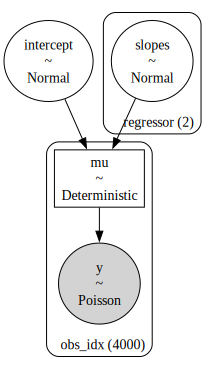

In [3]:
COORDS = {
    "regressor": ["meds", "alcohol"], 
    "obs_idx": sneezes.index
}

M, A, S = sneezes[["meds", "alcohol", "nsneeze"]].to_numpy().T

with pm.Model(coords=COORDS) as m_sneeze:
    # weakly informative Normal Priors
    a = pm.Normal("intercept", mu=0, sigma=5)
    b = pm.Normal("slopes", mu=0, sigma=1, dims="regressor")

    # define linear model
    mu = pm.Deterministic("mu", a + b[0] * M + b[1] * A, dims="obs_idx")

    ## Define Poisson likelihood
    y = pm.Poisson("y", mu=mu, observed=S, dims="obs_idx")

pm.model_to_graphviz(m_sneeze)


> ### Model coordinates
> 
> The model coordinates in PyMC are used to define dimensions and labels for the variables in the model. They provide a way to organize and manipulate the model's data with dimensions _names_ instead of raw _shapes_, through the `coords` and `dims` keyword arguments. In the given PyMC model, the coordinates are defined as follows:
> 
> - `regressor`: This coordinate represents the regressor variables in the model, which are `'meds'` and `'alcohol'`.
> - `obs_idx`: This coordinate represents the index of the observations in the model. It is a `RangeIndex` object with a range from 0 to 4000.
> 
> These coordinates allow for more intuitive and readable model specification, as well as easier manipulation and analysis of the model's data.


### Model Fitting

Most GLMs will be fit using the NUTS step method.

In [4]:
with m_sneeze:
    trace_sneeze = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


While the model sampled to completion, close inspection of the model reveals an issue that could have caused the sampler to fail. Can you spot it? In prevoious versions of PyMC, this model would have failed to sample.

Propose a more robust version below.

In [5]:
# Write your answer here

Before looking at the results, let's take a step back: the trick we used with the exponential is actually exactly how generalized linear models are defined. The exponential here is called **a link function**, and it's used to map the **output of our linear model** (a priori allowed to live in $(-\infty, \infty)$,

### Link functions

In Generalized Linear Models (GLMs), link functions play a crucial role in connecting the linear predictor to the response variable. The concept of link functions arises from the need to model the relationship between the mean of the response variable and the linear predictor, which can take any real value.

The link function transforms the linear predictor to ensure that the predicted values of the response variable are within a valid range and satisfy the distributional assumptions of the response variable. It maps the linear predictor to the space of the relevant parameter of the response distribution.

Different types of GLMs use different link functions based on the nature of the response variable and the desired distribution. Some commonly used link functions include:

1. Identity Link: This link function is used for continuous response variables and maintains a linear relationship between the linear predictor and the mean of the response variable.

2. Logit Link: This link function is used for binary response variables and maps the linear predictor to the probability of success in a logistic regression model. It ensures that the predicted probabilities are between 0 and 1.

3. Log Link: This link function is used for count data and maps the linear predictor to the mean of a Poisson distribution. It ensures that the predicted mean is positive.

4. Inverse Link: This link function is used for modeling the mean of a Gamma distribution and maps the linear predictor to the inverse of the mean.

The choice of the link function depends on the nature of the response variable and the assumptions of the distribution. The link function allows for flexible modeling of the relationship between the linear predictor and the response variable, enabling the estimation of regression coefficients and making predictions within the appropriate range of the response distribution.

### Checking our inferences

Now is the time to check if our model's results are credible. We will explore model checking in detail later in the course, but for now, we can use a simple technique: posterior predictive checks.

Posterior predictive checks (PPCs) are a great way to validate a model. The idea is to generate data from the model using parameters from the posterior distribution and compare these samples to the observed data.

In [6]:
def plot_sneeze_predictions(idata, color="C0"):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    az.plot_ppc(
        idata,
        ax=axs[0, 0],
        coords={
            "obs_idx": np.where(np.logical_and(sneezes.alcohol == 0, sneezes.meds == 0))
        },
        color=color,
    )
    az.plot_ppc(
        idata,
        ax=axs[0, 1],
        coords={
            "obs_idx": np.where(np.logical_and(sneezes.alcohol == 0, sneezes.meds == 1))
        },
        color=color,
    )
    az.plot_ppc(
        idata,
        ax=axs[1, 0],
        coords={
            "obs_idx": np.where(np.logical_and(sneezes.alcohol == 1, sneezes.meds == 0))
        },
        color=color,
    )
    az.plot_ppc(
        idata,
        ax=axs[1, 1],
        coords={
            "obs_idx": np.where(np.logical_and(sneezes.alcohol == 1, sneezes.meds == 1))
        },
        color=color,
    )
    axs[0, 0].set_title("No alcohol : No meds")
    axs[0, 1].set_title("No alcohol : Meds")
    axs[1, 0].set_title("Alcohol : No meds")
    axs[1, 1].set_title("Alcohol : Meds")
    return fig, axs

In [11]:
with m_sneeze:

    # Get posterior predictive samples, and add them to the InferenceData object
    trace_sneeze.extend(pm.sample_posterior_predictive(trace_sneeze))

Sampling: [y]


Output()

/home/cfonnesbeck/miniforge3/envs/bayes_course/lib/python3.12/site-packages/arviz/plots/ppcplot.py:242: FutureWarning: color has been deprecated in favor of colors
  warnings.warn("color has been deprecated in favor of colors", FutureWarning)


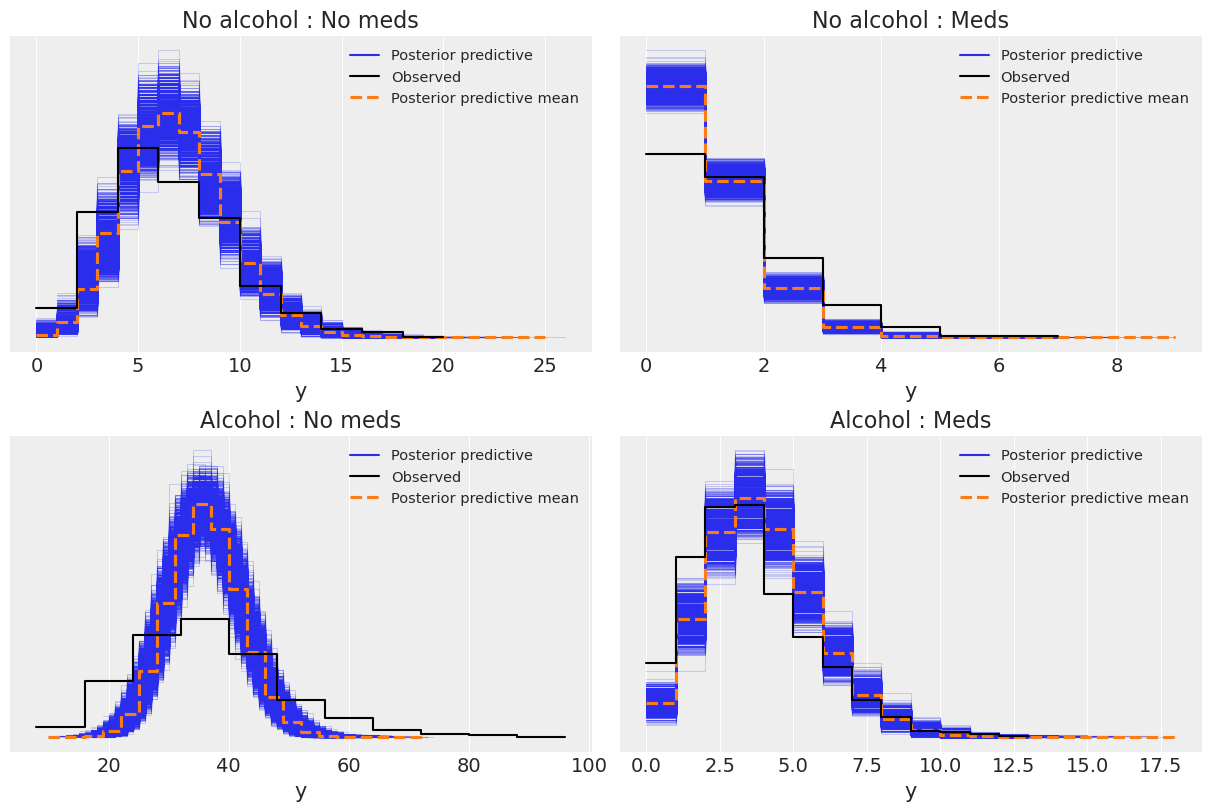

In [12]:
plot_sneeze_predictions(trace_sneeze);

While the model is in the ballpark of the actual data, it is not perfect. The model is underestimating the variance in the data. This is a common issue with Poisson regression, as the variance is constrained to be equal to the mean. When the data's mean and variance are not similar, a Poisson regression will underestimate the variance compared to the true variance observed in the data.

This behavior is quite common with Poisson regression: it often underestimates the variation in the data, simply because real data are more dispersed than our regression expects -- in these cases, data are said to be "overdispersed".

This phenomenon is particularly accute with the Poisson, because as we have seen its variance is mathematically constrained to be equal to its mean. So, when the data's mean and variance are not similar, a Poisson regression will get the variance estimate wrong when compared to the true variance observed in the data.

To convince ourselves, let's compare our data's mean and variance:

In [13]:
sneezes.groupby(["meds", "alcohol"])["nsneeze"].agg(["mean", "var"])

mean         var
meds alcohol                    
0    0         5.996    9.557542
     1        36.006  158.450414
1    0         1.005    1.134109
     1         3.099    4.255454

Notice that for each combination of `alcohol` and `meds`, the variance of `nsneeze` is higher than the mean!

## Gamma-Poisson Model

Gamma-Poisson (aka [Negative binomial](https://en.wikipedia.org/wiki/Negative_binomial_distribution)) regression is used to model overdispersion in count data. The Gamma-Poisson distribution can be thought of as a Poisson distribution whose rate parameter is gamma distributed, so that rate parameter can be adjusted to account for the increased variance. If you want more details about these models (a.k.a. "continuous mixture models"), I refer you to chapter 12 of [Richard McElreath's excellent _Statistical Rethinking_](https://nbviewer.jupyter.org/github/pymc-devs/resources/blob/master/Rethinking_2/Chp_12.ipynb).

In addition to the Poisson rate, $\lambda$, Gamma-Poisson distributions are parametrized an additional overdispersion parameter, $\alpha$, which controls the shape of the Gamma distribution. 

_The Gamma-Poisson distribution_

We start with a random variable $Y$ that follows a Poisson distribution with rate $\lambda$. Turns out $\lambda$ is also random, and it follows a gamma distribution with parameters $\mu$ and $\alpha$

$$
\begin{aligned}
Y &\sim \text{Poisson}(\lambda) \\
\lambda &\sim \text{Gamma}\left(\mu, \alpha\right)
\end{aligned}
$$


We can marginalize over $\lambda$


$$
\begin{aligned}
p(y \mid \mu, \alpha) &= \int_0^{\infty}{p(y \mid \lambda) p(\lambda \mid \mu, \alpha) d\lambda} \\
&= \binom{y + \alpha - 1}{y}{\left(\frac{\alpha}{\mu + \alpha}\right)}^\alpha {\left(\frac{\mu}{\mu + \alpha}\right)}^y
\end{aligned}
$$


The above describes the probability mass function of a Gamma-Poisson distribution, then we can say 

$$
Y \sim \text{GammaPoisson}(\mu, \alpha)
$$


### Why is it useful?

Well, it relieves us from the previous constraint of our Poisson Distribution, to fix the **mean** to the **variance**.

<br> </br>

<center>
  <img src="images/poisson_gamma_poisson_drake.png" style="width:500px"; />
</center>

The common name for this type of model is [negative binomial](https://en.wikipedia.org/wiki/Negative_binomial_distribution) regression.  The negative binomial distribution has two parameters: the mean $\mu$ and the overdispersion parameter $\alpha$. The mean $\mu$ is the rate parameter of the Poisson distribution, and the overdispersion parameter $\alpha$ controls the variance of the distribution.

We'll use the following model...


$$
\begin{aligned}
\beta_{\text{intercept}} &\sim \mathrm{Normal}(0, 5)\\
\beta_{\text{alcohol}} &\sim \mathrm{Normal}(0, 1)\\
\beta_{\text{meds}} &\sim \mathrm{Normal}(0, 1) \\
\alpha &\sim \mathrm{Exponential}(1) \\
\mu_i &= \exp(\beta_{\text{intercept}} + \beta_{\text{meds}} \text{meds}_i + \beta_{\text{alcohol}} \text{alcohol}_i) \\
Y \mid \mu_i, \alpha &\sim \mathrm{NegativeBinomial}(\mu_i, \alpha) \\
\end{aligned}
$$

Let's use this likelihood in PyMC:

In [13]:
with pm.Model(coords=COORDS) as m_sneeze_gp:
    # weakly informative priors
    a = pm.Normal("intercept", mu=0, sigma=5)
    b = pm.Normal("slopes", mu=0, sigma=1, dims="regressor")
    alpha = pm.Exponential("alpha", 1.0)

    # define linear model
    λ = pm.math.exp(a + b[0] * M + b[1] * A)

    ## likelihood
    y = pm.NegativeBinomial("y", mu=λ, alpha=alpha, observed=S, dims="obs_idx")

    trace_sneeze_gp = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


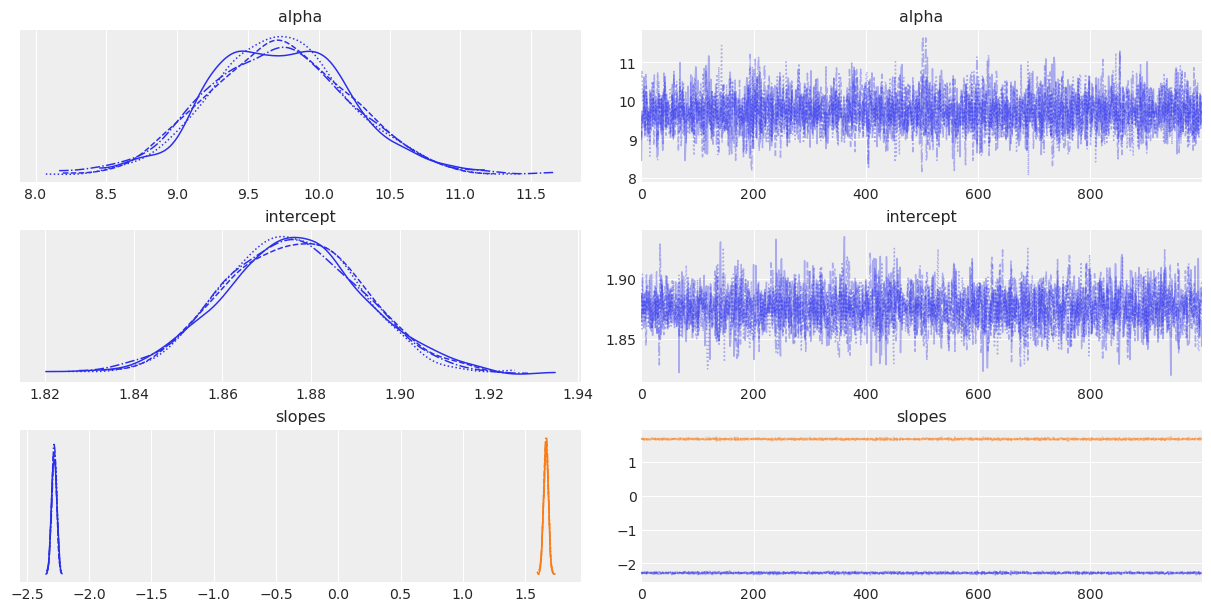

In [14]:
az.plot_trace(trace_sneeze_gp);

Sampling went well; let's quickly check the fit.

Sampling: [y]


Output()

/home/cfonnesbeck/miniforge3/envs/bayes_course/lib/python3.12/site-packages/arviz/plots/ppcplot.py:242: FutureWarning: color has been deprecated in favor of colors
  warnings.warn("color has been deprecated in favor of colors", FutureWarning)


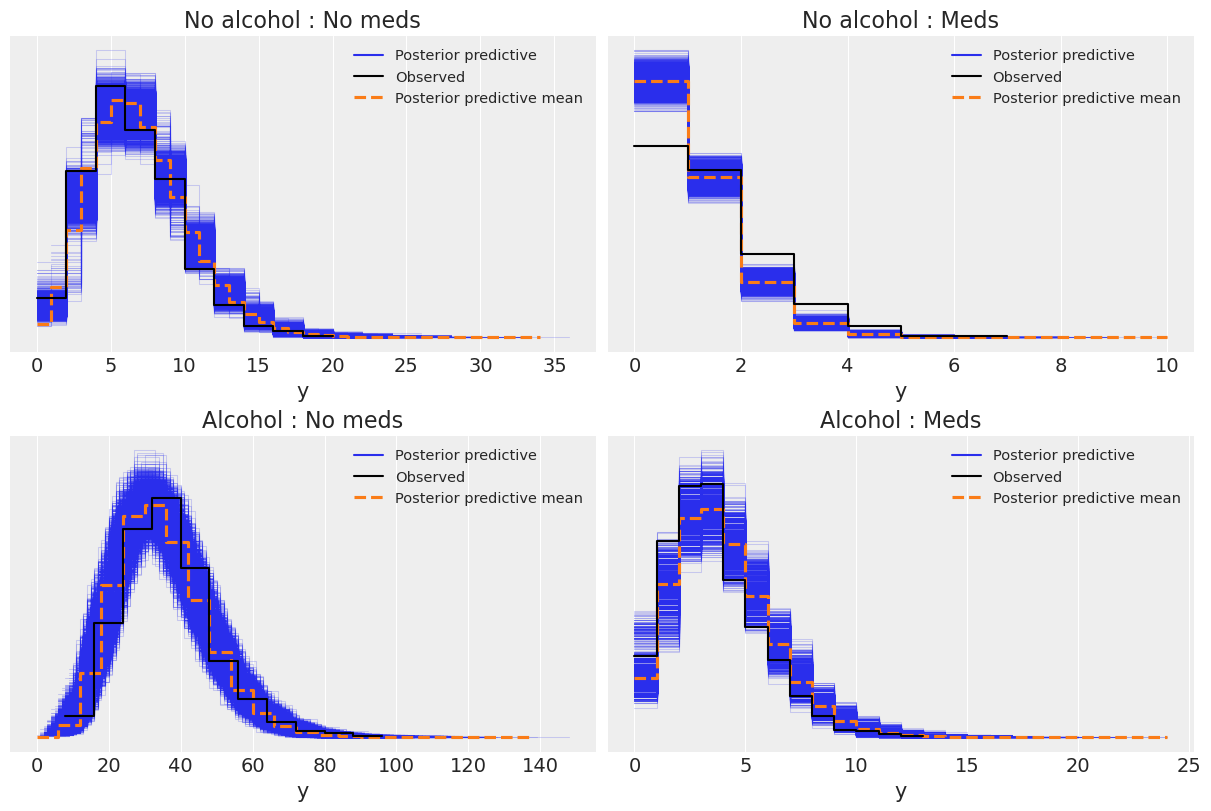

In [15]:
with m_sneeze_gp:
    trace_sneeze_gp.extend(pm.sample_posterior_predictive(trace_sneeze_gp))

plot_sneeze_predictions(trace_sneeze_gp);

The predictions look much better than before, **but** we can see there is bias relativee to the observations in some groups. For example, in the plot for no alcohol with medication the model is biased to predict fewer sneezes than we actually observe in the medication condition, and the opposite phenomenon in the no medication condition. 

This suggests that we are missing some sort of **interaction effect** between medication and alcohol consumption. The thing is that our model is only able to account for the mean sneezes across both conditions.

Try your hand at adding an interaction term to the model:

In [16]:
# Write your answer here

In [18]:
COORDS["regressor"] = ["meds", "alcohol", "interaction"]
with pm.Model(coords=COORDS) as m_sneeze_inter:
    # weakly informative priors
    a = pm.Normal("intercept", mu=0, sigma=5)
    b = pm.Normal("slopes", mu=0, sigma=1, dims="regressor")
    α = pm.Exponential("α", 1.0)

    # linear model
    λ = pm.math.exp(a + b[0] * M + b[1] * A + b[2] * M * A)

    ## likelihood
    y = pm.NegativeBinomial("y", mu=λ, alpha=α, observed=S, dims="obs_idx")

    trace_sneeze_inter = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, α]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


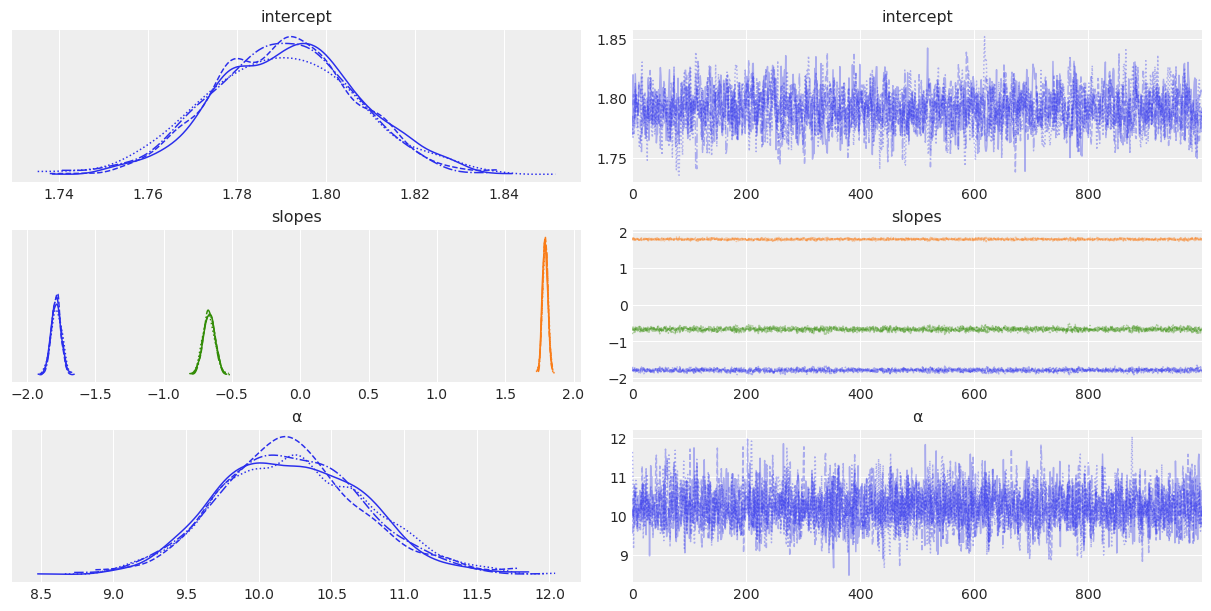

In [19]:
az.plot_trace(trace_sneeze_inter);

We see that the slope for the interaction is reliably negative, meaning that taking meds when drinking alcohol will still tame the effects of the latter on sneezing and thus decrease the number of sneezes compared to not taking meds.

Sampling: [y]


/Users/afengler/miniconda3/envs/iqvia_workshop/lib/python3.11/site-packages/arviz/plots/ppcplot.py:241: FutureWarning: color has been deprecated in favor of colors
  warnings.warn("color has been deprecated in favor of colors", FutureWarning)


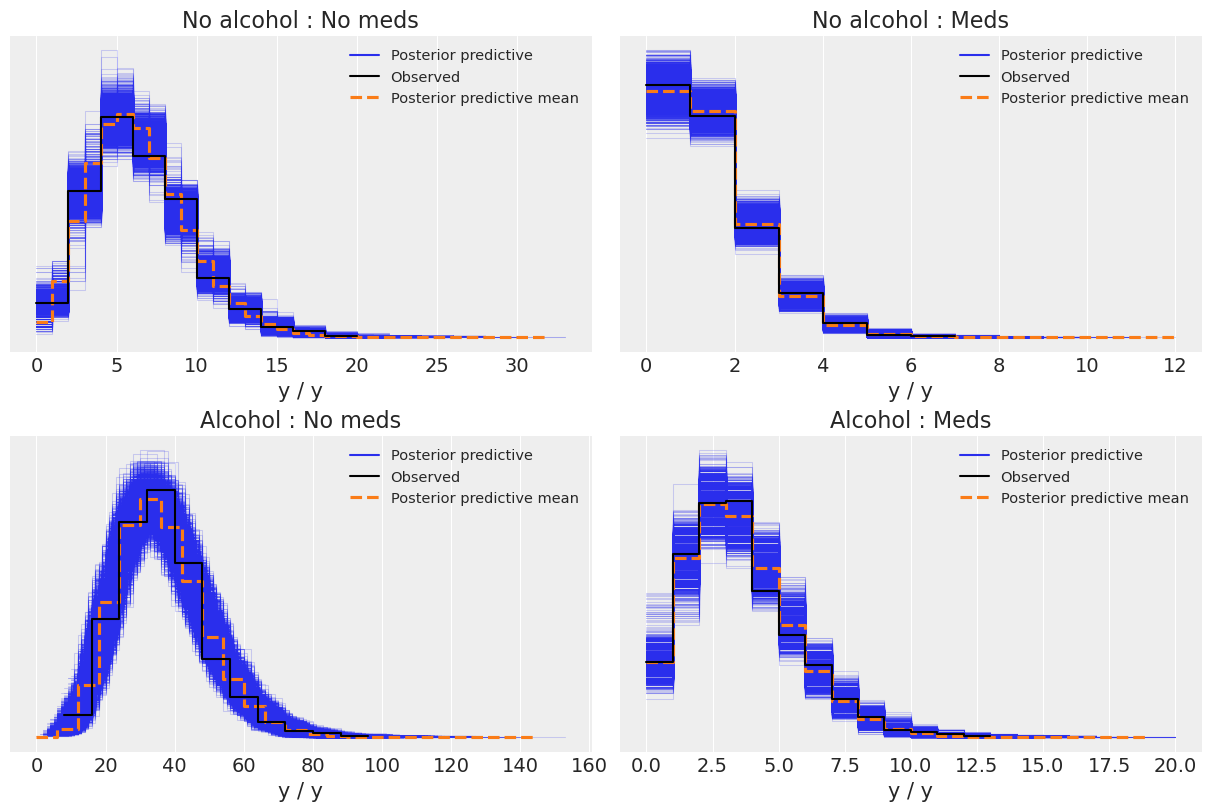

In [20]:
with m_sneeze_inter:
    trace_sneeze_inter.extend(pm.sample_posterior_predictive(trace_sneeze_inter))

plot_sneeze_predictions(trace_sneeze_inter);

And indeed, we see that our model's predictions are even better than before! We can see that our prediction biases have mostly disappeared and as a consequence, we have much better predictions for low numbers of sneezes.

## Generalized Linear Models 
### (Optional Theory Prelude)

The **Poisson regression** model we just created falls under the category of **Generalized Linear Models**. This is a family of models that contains many kind of regression models we usually work with, such as Poisson regresion, Logistic regression (as we'll see below), and many more. In this section, we cover how all the pieces fit together.

### Linear Models

We assume the conditional distribution of the response variable is a normal distribution. We model the mean of that normal distribution with a linear combination of the predictors. Mathematically, we have

$$
\begin{aligned}
\pmb{\beta} &\sim \mathcal{P}_{\pmb{\beta}} \\
\sigma &\sim \mathcal{P}_\sigma \\
\mu_i &= \beta_0 + \beta_1 X_{1i} + \cdots + \beta_p X_{pi} \\
Y_i \mid \mu_i, \sigma &\sim \text{Normal}(\mu_i, \sigma)
\end{aligned}
$$

where $\mathcal{P}_{\pmb{\beta}}$ is the joint prior for the regression coefficients and $\mathcal{P}_\sigma$ is the prior on the residual standard deviation.

### Generalized Linear Models

In Generalized Linear Models, we are not restricted to normal likelihoods and we model a function of the mean with a linear combination of the predictors.

$$
\begin{aligned}
\pmb{\beta} &\sim \mathcal{P}_{\pmb{\beta}} \\
\pmb{\theta} &\sim \mathcal{P}_{\pmb{\theta}} \\
g(\mu_i) &= \beta_0 + \beta_1 X_{1i} + \cdots + \beta_p X_{pi} \\
Y_i \mid \mu_i, \pmb{\theta} &\sim \mathcal{D}(\mu_i, \pmb{\theta})
\end{aligned}
$$

In GLM literature we have

* $\eta_i = \beta_0 + \beta_1 X_{1i} + \cdots + \beta_p X_{pi}$ is the **linear predictor**
* $g$ is the **link function**
    * In the Poisson regression model $g$ is the $\log$ function.
    * This point raises a lot of questions, as we directly work with the inverse link function $g^{-1}$ ($\exp$ in the previous case)
    * $g: \Omega \to \mathbb{R}$
    * $g^{-1}: \mathbb{R} \to \Omega$
    * $\Omega$ is the space of the mean parameter
* $\mathcal{D}$ is the **random component**
    * The conditional distribution of the response variable $Y$
    * Is not necessarily normal

Linear Models are specific case of Generalized Linear Models where $\mathcal{D} \equiv \mathcal{N}$ and $g = \text{identity}$

## Binomial regression

<br> </br>
<center><img src="https://media.giphy.com/media/C9b7PXxqueVxK/giphy.gif" style="margin:auto" height="350" width="350"/></center>

<br> </br>

In France, presidents are elected for five years. In the meantime, lots of polls are conducted to try and gauge the president's popularity, which often drives his reelection chances. In statistics, we call that "survey data", and the fun thing about them is that are perfectly imperfect: measurements can be biased, the polling houses' sampling methods can be wrong, people answer less and less to pollsters, etc. For statisticians, this is a delight!

Here, these polls are trying to answer one main question: if a referendum were held today where people have to say whether they approve or disapprove of the president, what would be the result? In other words, polls are a noisy estimate of the president's true, latent popularity. This is a great setting for a statistical model, right?

### Show me the data!

We compiled all the popularity opinion polls for Emmanuel Macron, the current French president. 

Let's see what the data look like, before diving into the model:

In [3]:
polls = pd.read_csv("../data/macron_popularity.csv")
polls

,date,president,party,pollster,method,N_approve,N_disapprove,N_total,unemployment
0,2017-05-17,macron,center,Elabe,internet,450,460,910,9.2
1,2017-05-20,macron,center,Ifop,phone,603,302,905,9.2
2,2017-05-20,macron,center,Ipsos,internet,467,274,741,9.2
3,2017-05-21,macron,center,Viavoice,internet,493,302,795,9.2
4,2017-05-23,macron,center,BVA,internet,627,354,981,9.2
...,...,...,...,...,...,...,...,...,...
350,2021-01-08,macron,center,Ifop,internet,463,565,1028,7.7
351,2021-01-14,macron,center,Odoxa,internet,401,602,1003,7.7
352,2021-01-23,macron,center,Ipsos,internet,350,600,950,7.7
353,2021-01-31,macron,center,Kantar,face-to-face&internet,780,1120,1900,7.7


The most important column here is `N_approve`, the number of people who approve of Macron. What we want is a model that takes these polls as raw inputs and infers the true latent proportion of people who do approve of the president.

### Build me a model

The polls are, quite simply, realizations of a Binomial distribution: for each poll, a number $N_{\text{total}}$ of people are surveyed, and $N_{\text{approve}}$ of them say they approve of the president's job. Statistically speaking, we have 


$$N_{\text{approve}} \sim \mathrm{Binomial}(N_{\text{total}}, p_{\text{approve}})$$


where $p_{\text{approve}}$ equals the proportion of people supporting the president. So now we just need a prior over $p_{\text{approve}}$.

Well this is a *success probability*, hence it's values resides in the interval $[0, 1]$. A good prior for this usually is a Beta distribution, we have seen it before!

Beta distributions are parametrized by two positive reals, $\alpha$ and $\beta$. Remember that $\alpha$ and $\beta$ usually don't have a real meaning, so it's often easier to parametrize the Beta distribution with two other parameters, $p$ and $\theta$, which roughly corresponding to the mean and how much *prior data* we base our beliefs on: for a given $p$, a higher $\theta$ means that the distribution around $p$ is narrower.

French presidents are usually not that popular, at least compared to the US. So a mean approval around 40% seems reasonable -- we have our prior for $p$! For $\theta$, a value of 2 translates to a uniform prior over probabilities, which is not what we want -- we _know_ presidential approval never goes below 10% and above 90%. To get that, we can set $\theta = 10$. You can play around with the code below to get a sense of how the Beta family behaves:

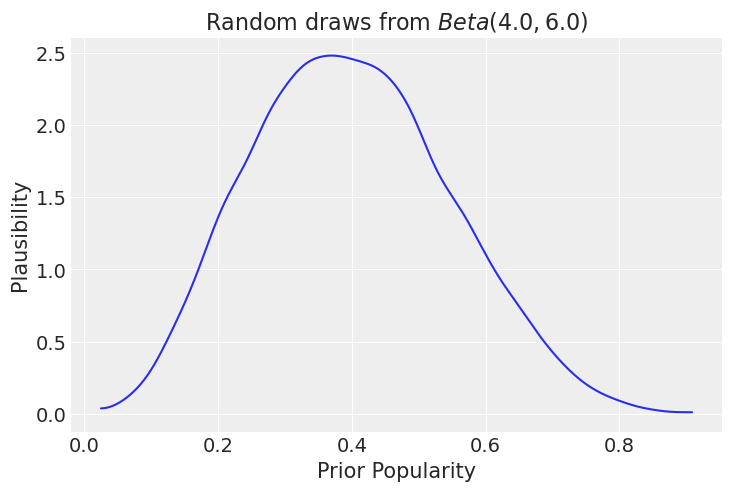

In [4]:
pbar = 0.4
theta = 10.0

ax = az.plot_dist(
    pm.draw(pm.Beta.dist(alpha=pbar * theta, beta=(1 - pbar) * theta), draws=10_000)
)
ax.set(
    title=f"Random draws from $Beta({pbar * theta}, {(1 - pbar) * theta})$",
    xlabel="Prior Popularity",
    ylabel="Plausibility",
);

Reminder: 

The mathematical link between $(p, \theta)$ and $(\alpha, \beta)$ is quite simple

---

$$
\begin{aligned}
\alpha &= p \times \theta \\
\beta &= (1 - p) \times \theta \\
\end{aligned}
$$

---

We now have all the parts of our (very simple, admittedly) model:

---

$$
\begin{aligned}
p_{\text{approve}} &\sim \mathrm{Beta(4, 6)}\\
N_{\text{approve}} &\sim \mathrm{Binomial}(N_{\text{total}}, p_{\text{approve}})\\
\end{aligned}
$$

---

Let's code that up and run it in PyMC:

In [5]:
with pm.Model() as m_raw:
    p_approve = pm.Beta("p_approve", alpha=4, beta=6)
    n_approve = pm.Binomial(
        "n_approve",
        n=polls.N_total.to_numpy(),
        p=p_approve,
        observed=polls.N_approve.to_numpy(),
    )

    trace_raw = pm.sample()
az.summary(trace_raw, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_approve]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p_approve,0.38,0.0,0.38,0.38,0.0,0.0,1750.39,2993.4,1.0


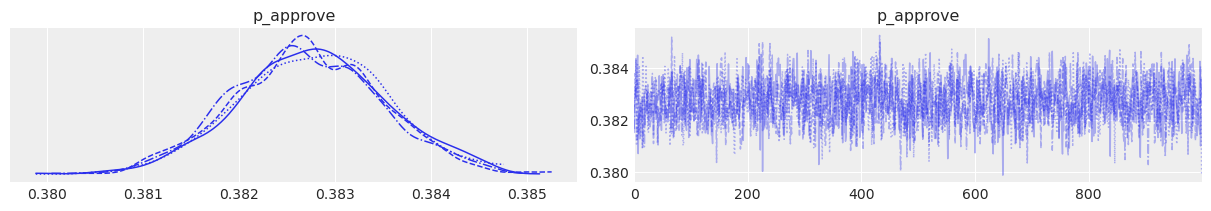

In [6]:
az.plot_trace(trace_raw);

Sampling went well, and we can see that the model is _very_ confident that Macron's popularity is around 38% (what did I tell you? That's what one calls a good prior, right? 😉): the posterior of `p_approve` basically goes from 0.380 to 0.386! 

It's because we have more than 300 polls, which is a lot. 

Of course, you, as a human, know that all those polls are not equal: those from 2017 should probably be discarded in 2021, but the model doesn't know that (we didn't tell it). Another reason is also that Binomial regressions in the wild tend to give overconfident estimates, for reasons similar to the Poisson, that we outlined above. If you add to that the fact that polls are noisy observations, which, again, we didn't tell the model, that's quite a lot of reasons not to trust the results here.

Actually, let's visualize posterior predictions of our model and see whether our skepticism is warranted:

Sampling: [n_approve]


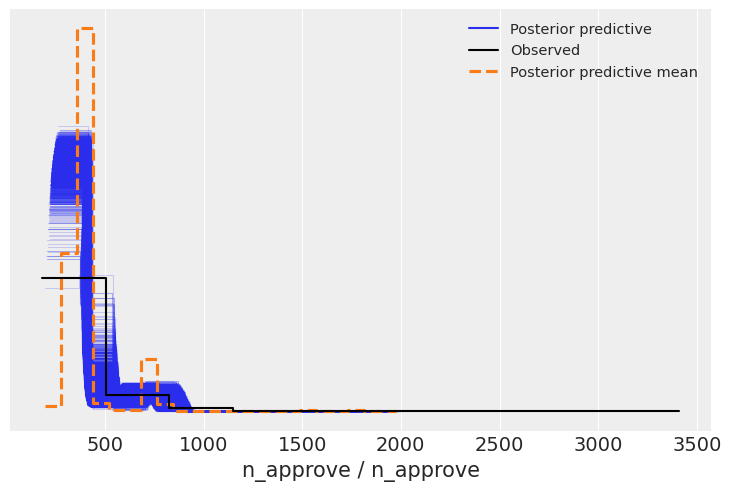

In [7]:
with m_raw:
    trace_raw.extend(pm.sample_posterior_predictive(trace_raw))
az.plot_ppc(trace_raw);

Wow, that doesn't look good! Something's off...

Actually, the default visualization returned by ArviZ is using different bins for the different posterior draws, the posterior predictive mean, and the observed data. This way, the comparison is not straightforward. Before making any conclusions about the model we should remove that additional noise. Have a look at the `plot_ppc_discrete` function below.

In [4]:
def adjust_lightness(color, amount=0.5):
    import colorsys

    import matplotlib.colors as mc

    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], c[1] * amount, c[2])


# Generate some graded colors
colors = [adjust_lightness("C0", x) for x in [1.8, 1.6, 1.4, 1.2, 0.9]]

# Quantiles corresponding to color gradings (used in plot below)
quantile_bands = [(0.05, 0.95), (0.15, 0.85), (0.25, 0.75), (0.35, 0.65)]


def plot_ppc_discrete(idata, bins, ax):
    # Add uncertainty bands around a line in plot
    def add_discrete_bands(x, lower, upper, ax, **kwargs):
        for i, (l, u) in enumerate(zip(lower, upper)):
            s = slice(i, i + 2)
            ax.fill_between(x[s], [l, l], [u, u], **kwargs)

    # Get data variable name
    var_name = list(idata.observed_data.data_vars)[0]
    # Extract observations form idata
    y_obs = idata.observed_data[var_name].to_numpy()

    counts_list = []
    for draw_values in az.extract(idata, "posterior_predictive")[var_name].to_numpy().T:
        counts, _ = np.histogram(draw_values, bins=bins)
        counts_list.append(counts)
    counts_arr = np.stack(counts_list)

    # Add quantile bands and median to plot
    for i in range(len(quantile_bands)):
        qts_tmp = np.quantile(counts_arr, quantile_bands[i], axis=0)
        add_discrete_bands(bins, qts_tmp[0], qts_tmp[1], ax=ax, color=colors[i])

    median = np.quantile(counts_arr, 0.5, axis=0)

    ax.step(bins[:-1], median, color=colors[4], lw=2, where="post")

    # Add ground truth to plot
    ax.hist(y_obs, bins=bins, histtype="step", lw=2, color="black", align="mid")

    # Add legend
    handles = [
        Line2D([], [], label="Observed data", color="black", lw=2),
        Line2D([], [], label="Posterior predictive median", color=colors[4], lw=2),
    ]
    ax.legend(handles=handles)

    return ax

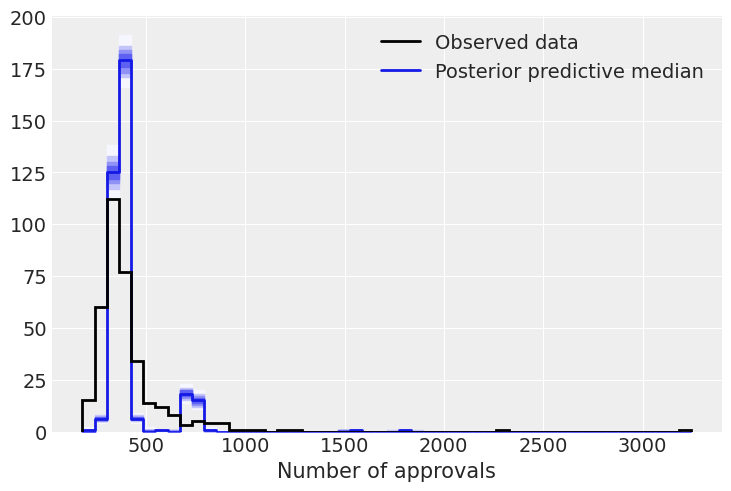

In [9]:
fig, ax = plt.subplots()
_, bins = np.histogram(polls["N_approve"], bins=50)
plot_ppc_discrete(trace_raw, bins, ax)
ax.set(xlabel="Number of approvals");

Wow, that doesn't look good! The model is not that bad for average to high approval numbers, but it is really bad at predicting low approval numbers, clearly overestimating their frequency. It's not _that_ surprising though: this model is very simple, while approval ratings are the results of complex socio-economic interactions that evolve with time. It's mainly an excuse to learn Binomial regression, and you'll see that these data are a good show case of incremental model building.

### Adding a predictor

A first thing we can do is help our model by adding a variable that's known or suspected to be well correlated with presidential approval. One such variable is unemployment, which we actually already have in our dataset -- yeah, sometimes life throws you some free gifts like that! 

More precisely, we will use the _logarithm_ of unemployment, not the raw unemployment rate. It's because we think that what matters for citizens when they think about unemployment is its _order of magnitude_, not its absolute value. Our model now looks like that:

$$
\begin{aligned}
\text{baseline} &\sim \mathrm{Normal}(-0.7, 0.5)\\
\beta_{\text{unemp}} &\sim \mathrm{Normal}(0, 0.2)\\
p_{\text{approve}} &= logistic(\text{baseline} + \beta_{\text{unemp}} \times \log(\text{unemp_data}))\\
N_{\text{approve}} &\sim \mathrm{Binomial}(N_{\text{total}}, p_{\text{approve}})\\
\end{aligned}
$$

#### It's all logistics!

How did I choose the priors? We'll get back to that in a minute, but first, did you notice the `logistic` link function? This has the same role as the exponential in the Poisson regression, except that the `logistic` function links the real line (here, the parameter space, where $baseline$ and $\beta_{\text{unemp}}$ live) to the $[0, 1]$ line (here, the outcome space, where $p_{\text{approve}}$ lives). Mathematically:

$$logistic(x) = \frac{1}{1 + e^{-x}}$$

Let's visualize this function to get a better understanding:

In [10]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

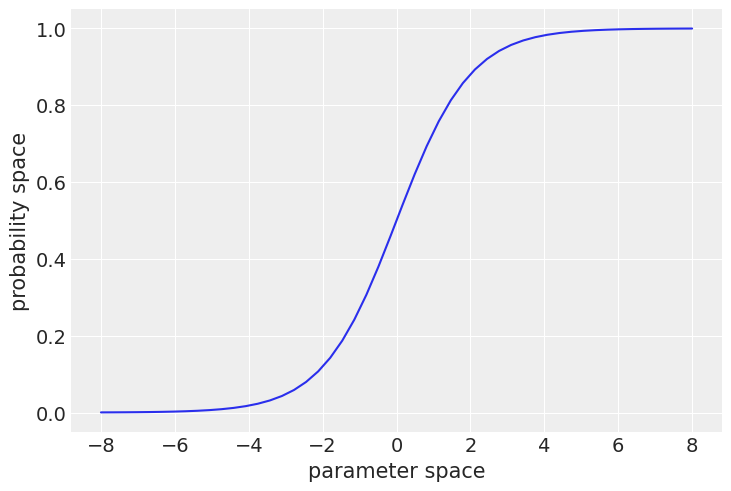

In [11]:
xvals = np.linspace(-8, 8)
plt.plot(xvals, logistic(xvals))
plt.xlabel("parameter space")
plt.ylabel("probability space");

Makes sense? If it still feels a bit fuzzy, it's perfectly normal. The more you use this function, the more you'll develop an intuition for it. For now, you can notice that 0 on the parameter space translates to a probability of 50%. Similarly, -4 is almost 0 and 4 is almost 1; -6 is _really_ 0 and 6 is _really_ 1. 

This means that the logistic strongly distorts the parameter space: only the numbers on $]-6, 6[$ have a probability different than 0 or 1. So priors that you _think_ are reasonable on the parameter space might turn out to be completely unreasonable on the probability space. In other words, **with GLMs you have to be _very_ careful when choosing priors, mainly because of the distortion of space caused by the link function**.

#### Selecting priors

We'll get back to them later, but **prior predictive checks are your friends** here -- repeat after me: "prior predictive checks are my friends!". Nonetheless, let's give you a preview here, shall we?

Our regression intercept is the baseline popularity. Imagine that we just did as usual and choose a classic $\mathrm{Normal}(0, 10)$ prior, which usually works well for the intercept of a linear regression. What does this mean on the outcome space?

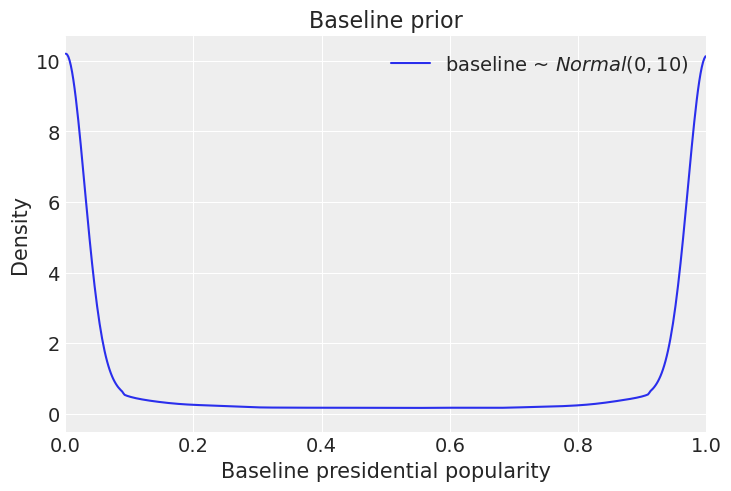

In [8]:
from scipy.special import expit as logistic

ax = az.plot_kde(
    logistic(pm.draw(pm.Normal.dist(mu=0, sigma=10), draws=20_000)),
    label="baseline ~ $Normal(0, 10)$",
)
ax.set_xlim((0, 1))
ax.set_xlabel("Baseline presidential popularity")
ax.set_ylabel("Density")
ax.set_title("Baseline prior");

Granted, those are pretty "rock on" horns 🤘 Apart from that, those priors are completely crazy, right? They actually expect the opposite of our domain knowledge! Because, when we think about it, we have quite a lot of information before seeing any polls: 50% popularity is historically high for a French president, so keeping the mean at zero (i.e $logistic(0) = 0.5$ on the outcome space) is sub-optimal. 

We can do better: we expect most presidents to have a baseline popularity between 20% and 50% -- in other words, French people rarely love their presidents but often _really_ dislike them. $\mathrm{Normal}(-0.7, 0.5)$ looks reasonable in that regard: it expects 95% of the probability mass to be between -1.7 and 0.3, i.e $logistic(-1.7) = 15\%$ and $logistic(0.3) = 57\%$, with a mean approval of $logistic(-0.7) = 33\%$:


#### Note

Remember our lecture on choosing priors. If you want to e.g. have $95\%$ of the mass in the prior on $logistic(p_{approve})$ lie within $15\%$ and $57\%$, you could also just check for the respective inputs to the *logistic* function ($-1.7$ and $0.3$ from above) and then request prior parameters via the,
`pm.find_constrained_prior` function!

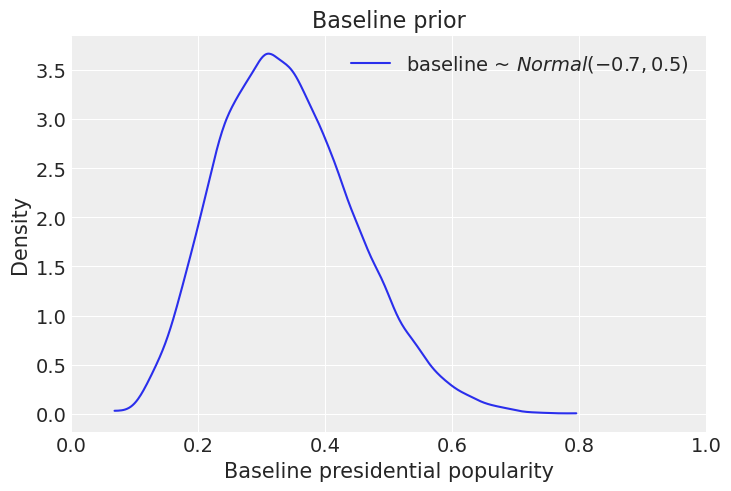

In [9]:
baseline_prior_samples = pm.draw(pm.Normal.dist(-0.7, 0.5), draws=20_000)

ax = az.plot_kde(
    logistic(baseline_prior_samples),
    label="baseline ~ $Normal(-0.7, 0.5)$",
)
ax.set_xlim((0, 1))
ax.set_xlabel("Baseline presidential popularity")
ax.set_ylabel("Density")
ax.set_title("Baseline prior");

Aaaah, that looks much better 🤩 

For the unemployment parameter though, we should expect a much milder effect. First, because socio-demographic variables usually have small effects in the literature. Second, because unemployment is not the only thing influencing voters' opinion of the president: there is also, notably, partisanship, which makes movements in popularity less responsive to unemployment -- if you really don't like the president, you probably need to see a very low unemployment rate before starting to credit him.

All in all, we expect the unemployment to have a small negative effect, but we're not sure. So, let's center our prior on $0$ (i.e no expected effect) and use a weakly regularizing $\sigma$ (in log-odds space): $\beta_{\text{unemp}} \sim \mathrm{Normal}(0, 0.2)$. To see the effect of this prior, we have to plug it into the formula for our model, $p_{\text{approve}} = logistic(baseline + \beta_{\text{unemp}} \times \log(\text{unemp_data}))$.

We just have to generate fake unemployment data. This is a good time to note that we'll standardize the real unemployment data (i.e force it to have mean 0 and standard deviation 1). Indeed that makes it easier to set our priors, and our sampler will have a better time sampling -- so, you know two 🐦 with one 💎 !

In [10]:
def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()


stdz_log_unemployment = standardize(np.log(polls.unemployment)).to_numpy()

So, as the data are standardized, simulating fake unemployment between -3 and 3 is largely sufficient to cover the whole range of possible data:

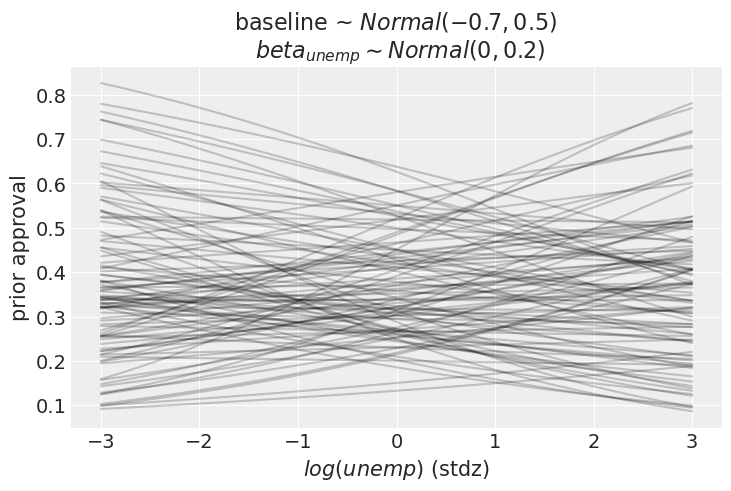

In [11]:
unemp_effect_prior_samples = pm.draw(pm.Normal.dist(0.0, 0.2), draws=20_000)
fake_unemp = np.linspace(-3, 3, 200)

prior_approval = logistic(
    baseline_prior_samples[:, None] + unemp_effect_prior_samples[:, None] * fake_unemp
)

for i in range(100):
    plt.plot(fake_unemp, prior_approval[i], "k", alpha=0.2)
plt.xlabel("$log(unemp)$ (stdz)")
plt.ylabel("prior approval")
plt.title("baseline ~ $Normal(-0.7, 0.5)$ \n $beta_{unemp} \sim Normal(0, 0.2)$");

Each line is a possible relationship, according to our model's assumptions, between unemployment and latent popularity, factoring in the baseline effect. And this looks quite nice, doesn't it? It's indeed quite realistic that popularity doesn't jump around each time unemployment changes. One thing we could think of adding though is an assumption that approval probably decreases when unemployment increases. But that's good enough for now.

#### Sampling from the model

We now have everything to fire up PyMC -- **let's team-code that one**!

In [34]:
# BREAKOUT ROOMS

# .... YOUR CODE

In [16]:
# SOLUTION
with pm.Model() as m_unemp:
    # intercept on logit scale
    baseline = pm.Normal("baseline", -0.7, 0.5)
    # log unemployment slope
    log_unemp_effect = pm.Normal("log_unemp_effect", 0.0, 0.2)

    # invlogit --> logistic
    p_approve = pm.math.invlogit(baseline + log_unemp_effect * stdz_log_unemployment)

    n_approve = pm.Binomial(
        "n_approve",
        n=polls.N_total.to_numpy(),
        p=p_approve,
        observed=polls.N_approve.to_numpy(),
    )

    trace_unemp = pm.sample()

az.summary(trace_unemp, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline, log_unemp_effect]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline,-0.48,0.0,-0.49,-0.48,0.0,0.0,4382.95,2967.99,1.0
log_unemp_effect,0.15,0.0,0.14,0.15,0.0,0.0,3593.22,2886.58,1.0


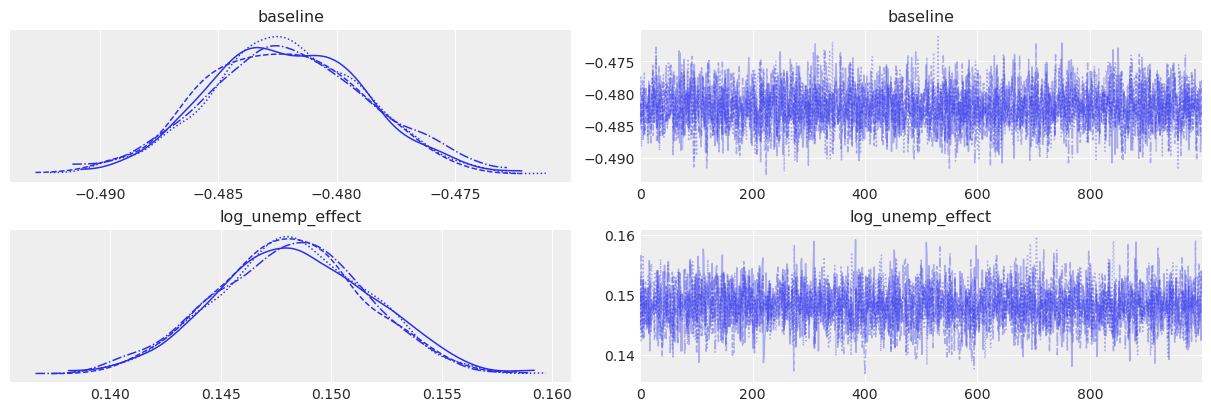

In [17]:
az.plot_trace(trace_unemp);

In [18]:
with m_unemp:
    trace_unemp.extend(pm.sample_posterior_predictive(trace_unemp))

Sampling: [n_approve]


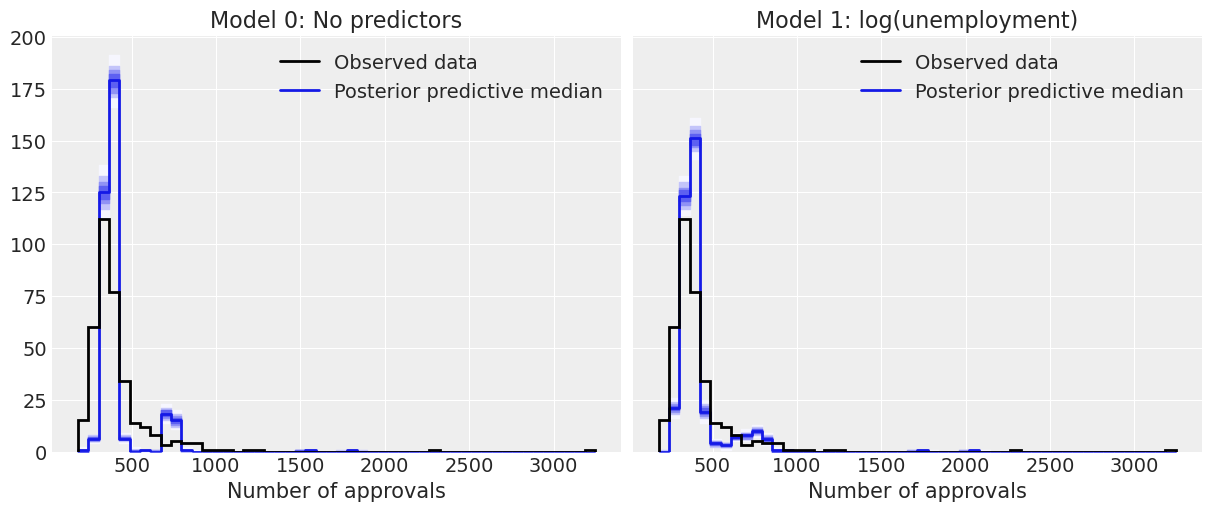

In [19]:
_, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True, sharey=True)
_, bins = np.histogram(polls["N_approve"], bins=50)

plot_ppc_discrete(trace_raw, bins, axes[0])
plot_ppc_discrete(trace_unemp, bins, axes[1])

axes[0].set(title="Model 0: No predictors", xlabel="Number of approvals")
axes[1].set(title="Model 1: log(unemployment)", xlabel="Number of approvals");

Mmmh, that looks a bit better, but not that much. The model still has troubles with low approval ratings. And yet, as you can see in the trace plot and summary above, it is still _very_ confident in its estimates. Both wrong _and_ overconfident? That's not a good combination! And it's time to tackle this overconfidence.


## Beta-Binomial regression

As we said earlier, Binomial regressions tend to give overconfident estimates, for reasons similar to the Poisson. So, as we used the Gamma-Poisson distribution to give more flexibility to the Poisson, we can use the [Beta-Binomial distribution](https://en.wikipedia.org/wiki/Beta-binomial_distribution), which handles overdispersed data -- i.e observations that are more variable than a classic Binomial distribution would expect and can accomodate.

As a result, the Binomial probabilities are no longer fixed, but are rather random variables drawn from a common Beta distribution. So, in addition to the number of trials, $n$, Beta-Binomial distributions are parametrized by two strictly positive reals, $\alpha$ and $\beta$. That rings a bell, doesn't it? These are the same two parameters we saw for the Beta distribution above. And, of course, we're going to use the same trick and parametrize it with $p$ and $\theta$ instead.

As a result, our model becomes:

$$
\begin{aligned}
\text{baseline} &\sim \mathrm{Normal}(-0.7, 0.5)\\
\beta_{\text{unemp}} &\sim \mathrm{Normal}(0, 0.2)\\
p_{\text{approve}} &= logistic(\text{baseline} + \beta_{\text{unemp}} \times \log(\text{unemp_data}))\\
\theta &\sim \mathrm{Exponential}(1) + 10\\
N_{\text{approve}} &\sim \mathrm{BetaBinomial}(\alpha=p_{\text{approve}} \times \theta, \beta = (1 - p_{\text{approve}}) \times \theta, \: N_{\text{total}})
\end{aligned}
$$

The difference with our very first Binomial model is that now we need a prior for $\theta$ -- before we fixed it at 10, but now we want to actually estimate it. The good news is that we already thought about this prior and decided that we want to assume that the precision is at least 10. To that end, we can use a trick and define $\theta = \tilde{\theta} + 10$, where $\tilde{\theta} \sim \mathrm{Exponential}(1)$, which works because exponential distributions have a minimum of zero. This is exactly what you see in the latex model above.

This translates easily into PyMC:

In [12]:
with pm.Model() as m_betabin:

    # data containers
    U = pm.MutableData("U", stdz_log_unemployment)
    N = pm.MutableData("N", polls.N_total.to_numpy())
    Y = pm.MutableData("Y", polls.N_approve.to_numpy())
    
    # intercept on logit scale
    baseline = pm.Normal("baseline", -0.7, 0.5)
    # log unemployment slope
    log_unemp_effect = pm.Normal("log_unemp_effect", 0.0, 0.2)

    # invlogit --> logistic
    p_approve = pm.Deterministic("p_approve", pm.math.invlogit(baseline + log_unemp_effect * U))

    # overdispersion parameter
    theta = pm.Exponential("theta_offset", 1.0) + 10.0

    n_approve = pm.BetaBinomial(
        "n_approve",
        alpha=p_approve * theta,
        beta=(1.0 - p_approve) * theta,
        n=N,
        observed=Y,
    )

    trace_betabin = pm.sample()

az.summary(trace_betabin, var_names="~p_approve", round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline, log_unemp_effect, theta_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline,-0.49,0.02,-0.53,-0.46,0.00,0.00,5792.26,3088.55,1.0
log_unemp_effect,0.12,0.02,0.08,0.16,0.00,0.00,6578.89,3394.24,1.0
theta_offset,18.56,2.13,14.65,22.57,0.03,0.02,5673.77,2921.82,1.0


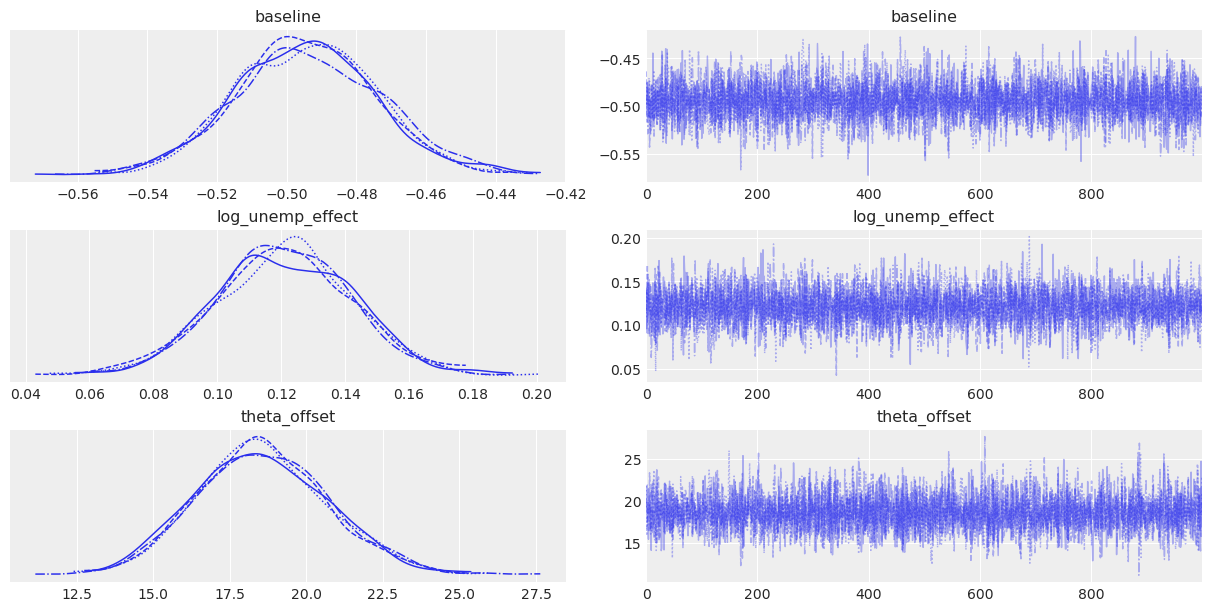

In [173]:
az.plot_trace(trace_betabin, var_names="~p_approve");

Note how the posterior distributions of `baseline` and `log_unemp_effect` are much wider than before -- that's already a good sign.

Now how are we doing on the predictions side?

In [13]:
with m_betabin:
    trace_betabin.extend(pm.sample_posterior_predictive(trace_betabin))

Sampling: [n_approve]


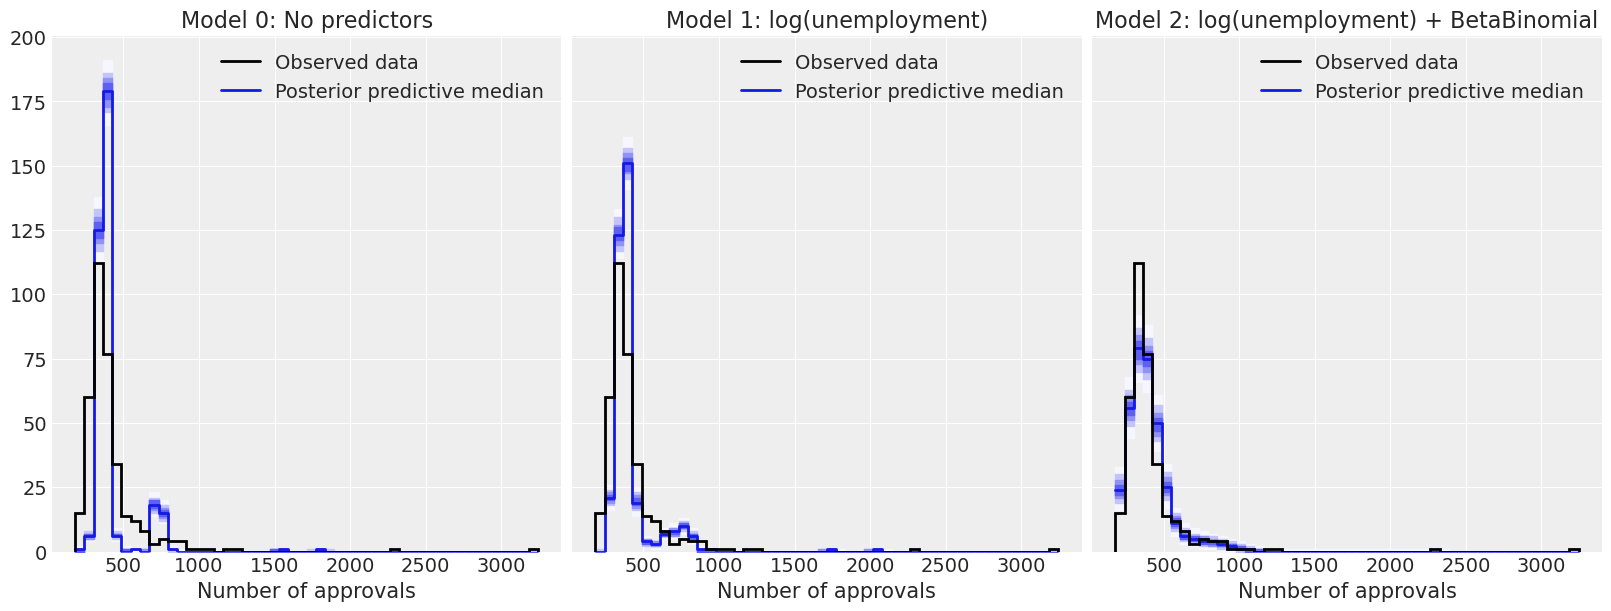

In [23]:
_, axes = plt.subplots(1, 3, figsize=(16, 6), constrained_layout=True, sharey=True)
_, bins = np.histogram(polls["N_approve"], bins=50)

plot_ppc_discrete(trace_raw, bins, axes[0])
plot_ppc_discrete(trace_unemp, bins, axes[1])
plot_ppc_discrete(trace_betabin, bins, axes[2])

axes[0].set(title="Model 0: No predictors", xlabel="Number of approvals")
axes[1].set(title="Model 1: log(unemployment)", xlabel="Number of approvals")
axes[2].set(
    title="Model 2: log(unemployment) + BetaBinomial", xlabel="Number of approvals"
);

That's the best we've seen so far! We keep improving!

<br> </br>
<center><img src="https://media.giphy.com/media/cNrZyXIZHSLYTqtWJI/giphy.gif" style="margin:auto" height="300" width="300"/></center>

<br> </br>


This is still not an amazing model, but it's never going to be -- we are keeping the model too simple here (but good enough for illustration purposes). But we can clearly see in the rightmost plot that the Beta-Binomial likelihood allows our model to be much more flexible and more able to accomodate the variation in the data. 

And note that this is not cheating: polls really are noisy observations of the latent truth, so it makes sense to allow the model to estimate one Binomial probability for each poll, which is basically what a Beta-Binomial is doing.

Our predictions still aren't very useful though: true, they could have generated the observed data now, but it's also because they became much less precise. In other words, we're on target now, but it's because we're shooting in many more directions than in the vanilla Binomial regression.

### How to improve this model?

There are many avenues to explore to make our predictions more precise. We could think about adding relevant predictor variables, using polling data from previous presidents (approval works in cycle, no matter who's president, so knowing about previous presidents would help), and adding a time component (we already noticed that polls from 2017 shouldn't weigh as much as polls from 2021). This last option would also allow us to do time series predictions, which is intrinsically interesting here.

There are many different methods to implement this time component, in combination with the two other options. You can take a look at:

- [Random walks](https://docs.pymc.io/api/distributions/timeseries.html#pymc3.distributions.timeseries.GaussianRandomWalk)
- [Gaussian Processes](https://alexandorra.github.io/pollsposition_blog/popularity/macron/gaussian%20processes/polls/2021/01/18/gp-popularity.html)
- [Splines](https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_04.ipynb)
- [Hidden Markov models](https://www.learnbayesstats.com/episode/14-hidden-markov-models-statistical-ecology-with-vianey-leos-barajas)
- [Dynamic Linear models](https://brandonwillard.github.io/dynamic-linear-models-in-theano.html)

Alex Andorra implemented the [random walk solution](https://alexandorra.github.io/pollsposition_blog/popularity/macron/hidden%20markov%20models/polls/2021/05/16/hmm-popularity.html) already (with a nice [interactive dashboard](https://www.pollsposition.com/popularity)), as well as a Gaussian Process, which you can check out [here](https://alexandorra.github.io/pollsposition_blog/popularity/macron/gaussian%20processes/polls/2021/01/18/gp-popularity.html).

### Coding Exercise

<br> </br>
<center><img src="https://media.giphy.com/media/l2JehQaTrsfXXxL56/giphy.gif" style="margin:auto" height="300" width="300"/></center>

<br> </br>

In our sequence of models, we are ignoring the following possibility. 

---

Maybe all we needed to improve our model predictions was the switch to the **Beta-Binomial** regression and unemployment didn't really play a role!

---


To rule that scenario out, we should also test the model that does not include the unemployment data, but makes use of the **Beta-Binomial** noise distribution. Let's do this as an exercise!

Try to code up the respective model and compare the results to the three previous ones from this section!

In [43]:
# BREAKOUT ROOMS

# ... YOUR CODE

In [24]:
# SOLUTION
with pm.Model() as m_betabin_no_unemp:
    # intercept on logit scale
    baseline = pm.Normal("baseline", -0.7, 0.5)

    # invlogit --> logistic
    p_approve = pm.math.invlogit(baseline)

    # overdispersion parameter
    theta = pm.Exponential("theta_offset", 1.0) + 10.0

    n_approve = pm.BetaBinomial(
        "n_approve",
        alpha=p_approve * theta,
        beta=(1.0 - p_approve) * theta,
        n=polls.N_total.to_numpy(),
        observed=polls.N_approve.to_numpy(),
    )

    trace_betabin_no_unemp = pm.sample()

az.summary(trace_betabin_no_unemp, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline, theta_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline,-0.49,0.02,-0.53,-0.45,0.00,0.00,3843.41,3041.79,1.0
theta_offset,16.08,1.96,12.62,19.90,0.03,0.02,4091.33,2797.14,1.0


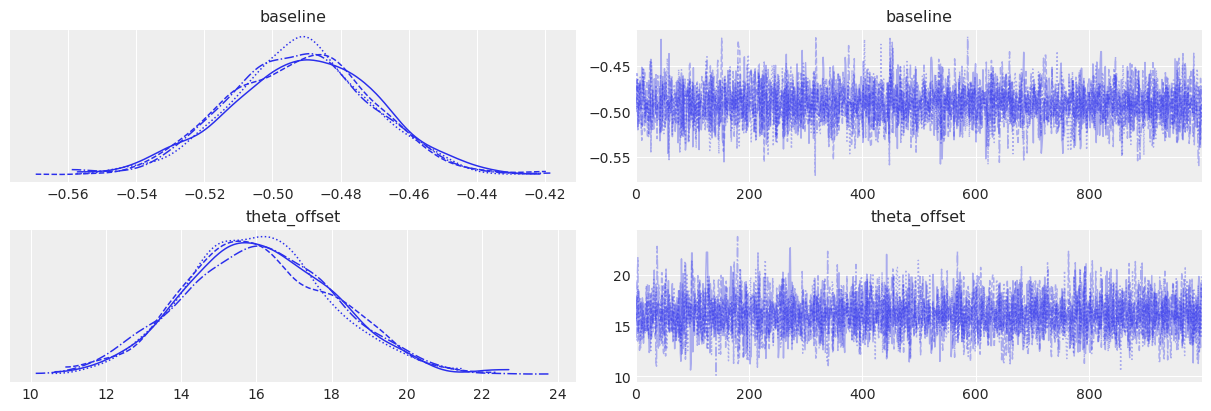

In [25]:
az.plot_trace(trace_betabin_no_unemp);

In [26]:
with m_betabin_no_unemp:
    trace_betabin_no_unemp.extend(
        pm.sample_posterior_predictive(trace_betabin_no_unemp)
    )

Sampling: [n_approve]


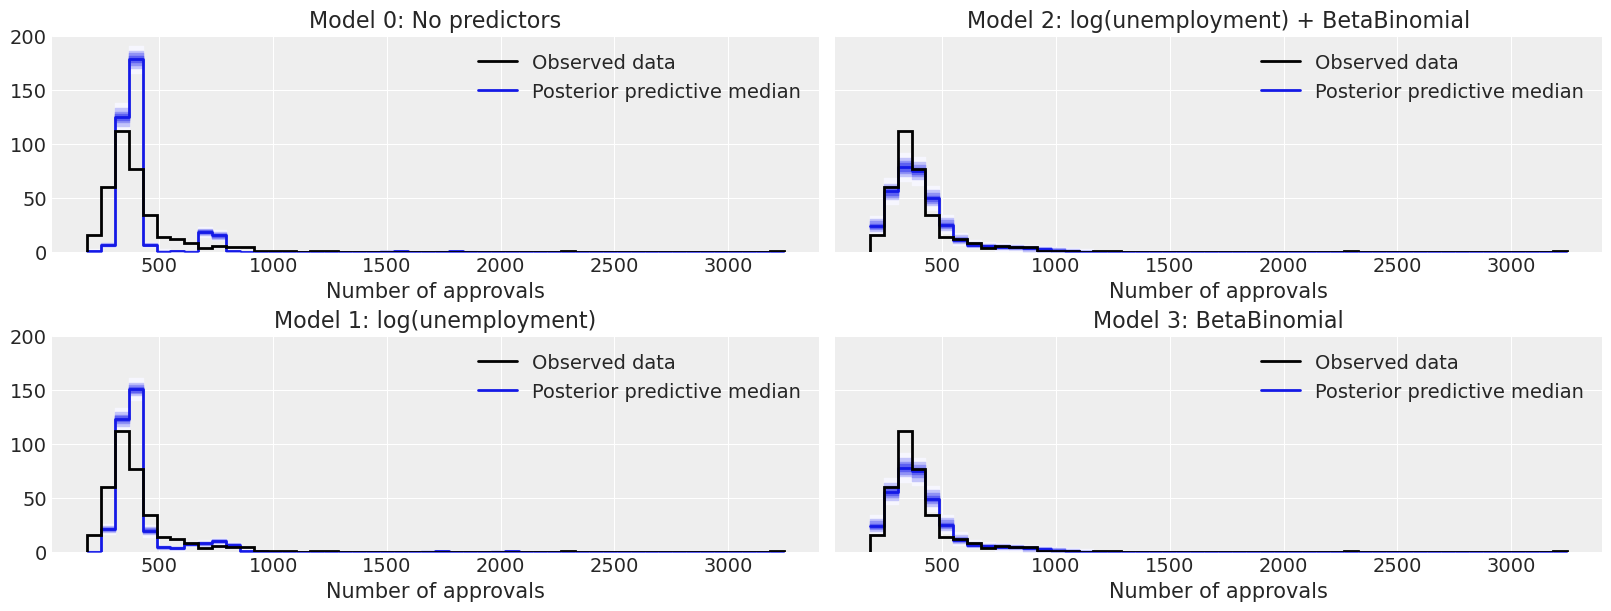

In [27]:
_, axes = plt.subplots(2, 2, figsize=(16, 6), constrained_layout=True, sharey=True)
_, bins = np.histogram(polls["N_approve"], bins=50)

plot_ppc_discrete(trace_raw, bins, axes[0, 0])
plot_ppc_discrete(trace_unemp, bins, axes[1, 0])
plot_ppc_discrete(trace_betabin, bins, axes[0, 1])
plot_ppc_discrete(trace_betabin_no_unemp, bins, axes[1, 1])


axes[0, 0].set(title="Model 0: No predictors", xlabel="Number of approvals")
axes[1, 0].set(title="Model 1: log(unemployment)", xlabel="Number of approvals")
axes[0, 1].set(
    title="Model 2: log(unemployment) + BetaBinomial", xlabel="Number of approvals"
)
axes[1, 1].set(title="Model 3: BetaBinomial", xlabel="Number of approvals");

<br> </br>
<center><img src="https://media.giphy.com/media/l2JdSxKfQhreOGdag/giphy.gif" style="margin:auto" height="350" width="350"/></center>

Ah... what have we here...
Looks like the $\operatorname{BetaBinomial}$ did all the work for us in the end...
This should serve as a good reminder to build models gradually so that we do not loose track of which model attributes are actually driving successfull inference.

<center> Alright, that shall be it for this lesson! </center>

<br> </br>

<center><img src="https://media.giphy.com/media/H9T1IO402BBio/giphy.gif" style="margin:auto" height="350" width="350"/></center>


<br> </br>

## Bonus: How to see how popularity changes as a function of unemployment?

### 1. Do it from scratch

#### Compute counterfactual approval

In [14]:
post = trace_betabin.posterior
fake_unemp = xr.DataArray(fake_unemp, dims="counterfactual")
post_approval = logistic(post["baseline"] + post["log_unemp_effect"] * xr.DataArray(fake_unemp))

#### Plot counterfactual approval

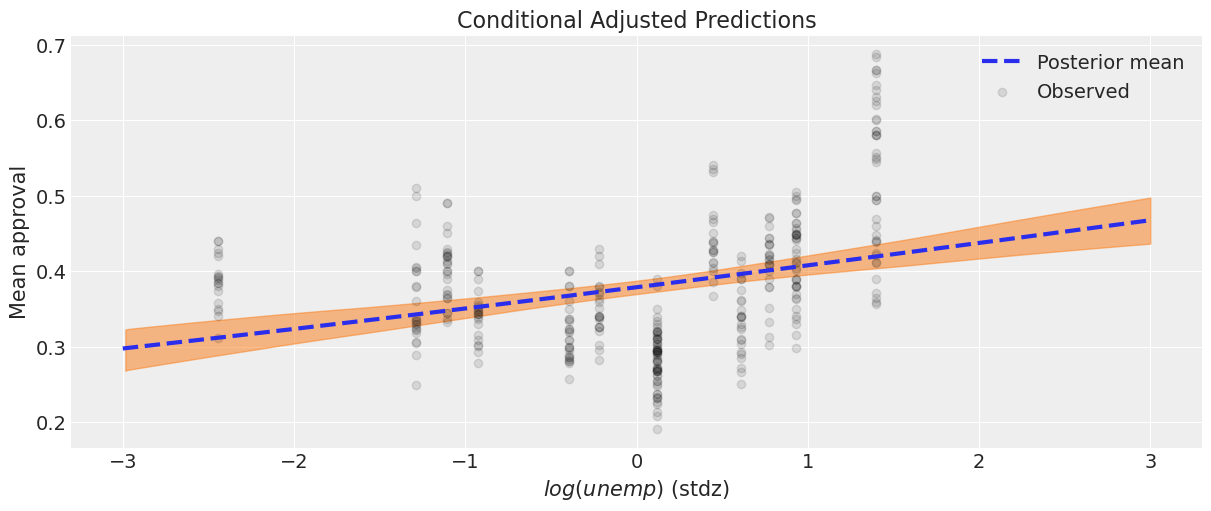

In [15]:
_, ax = plt.subplots(1, 1, figsize=(12, 5))

az.plot_hdi(fake_unemp, post_approval, ax=ax, backend_kwargs={"label": "Posterior HDI"})
ax.plot(fake_unemp, post_approval.mean(("chain", "draw")), ls="--", lw="3", label="Posterior mean")
ax.scatter(stdz_log_unemployment, polls["N_approve"] / polls["N_total"], c="k", alpha=0.1, label="Observed")

ax.set(xlabel="$log(unemp)$ (stdz)", ylabel="Mean approval", title="Conditional Adjusted Predictions")
ax.legend();

#### Another look at the data

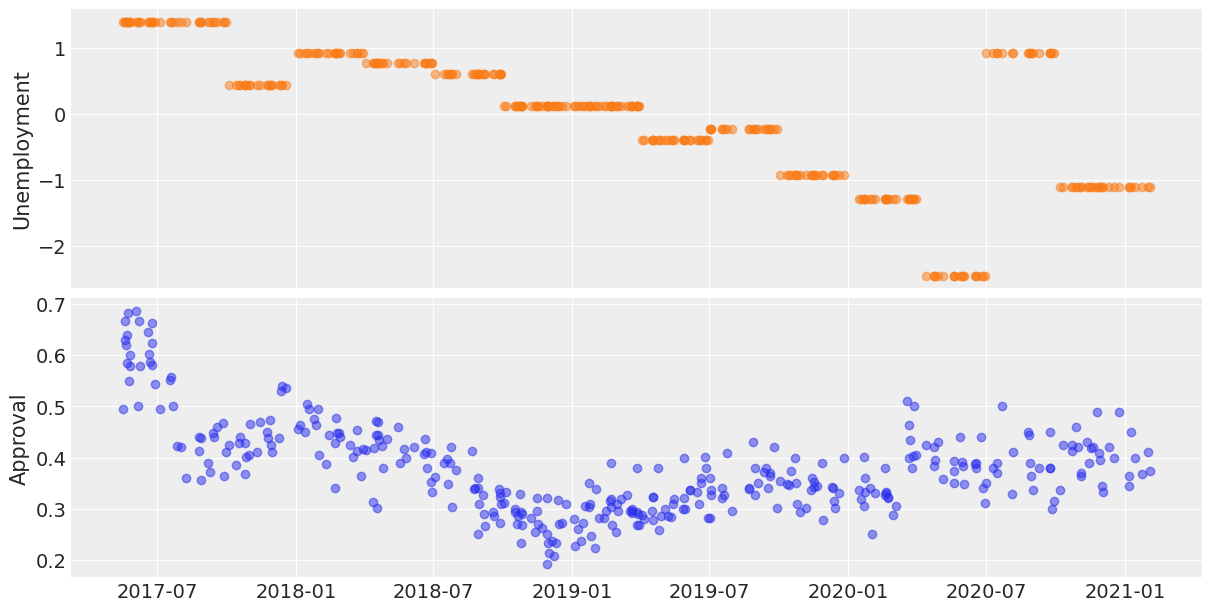

In [16]:
time = pd.to_datetime(polls["date"])

_, (up, down) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

up.scatter(time, stdz_log_unemployment, c="C1", alpha=0.5)
up.set(ylabel="Unemployment")

down.scatter(time, polls["N_approve"] / polls["N_total"], c="C0", alpha=0.5)
down.set(ylabel="Approval");

### 2. Just `do` it

#### Replace values of predictor

In [18]:
m_do = pm.do(m_betabin, {"U": fake_unemp})

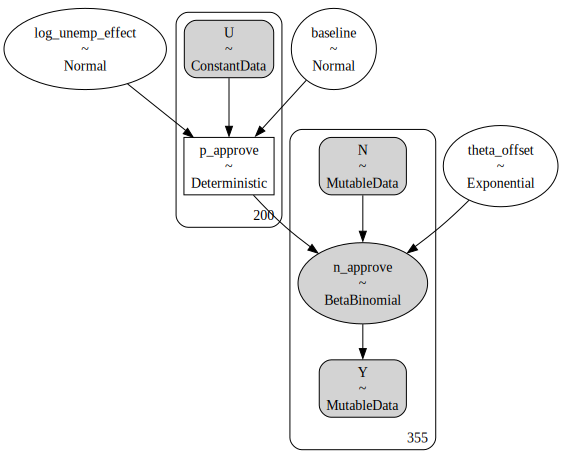

In [19]:
pm.model_to_graphviz(m_do)

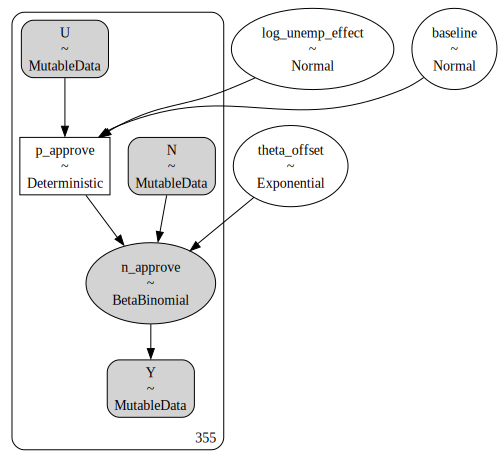

In [20]:
pm.model_to_graphviz(m_betabin)

#### Ask for predictions

In [21]:
with m_do:
    preds_do = pm.sample_posterior_predictive(trace_betabin, var_names=["p_approve"])

Sampling: []


#### Plot predictions

In [24]:
post_approval = preds_do.posterior_predictive["p_approve"]

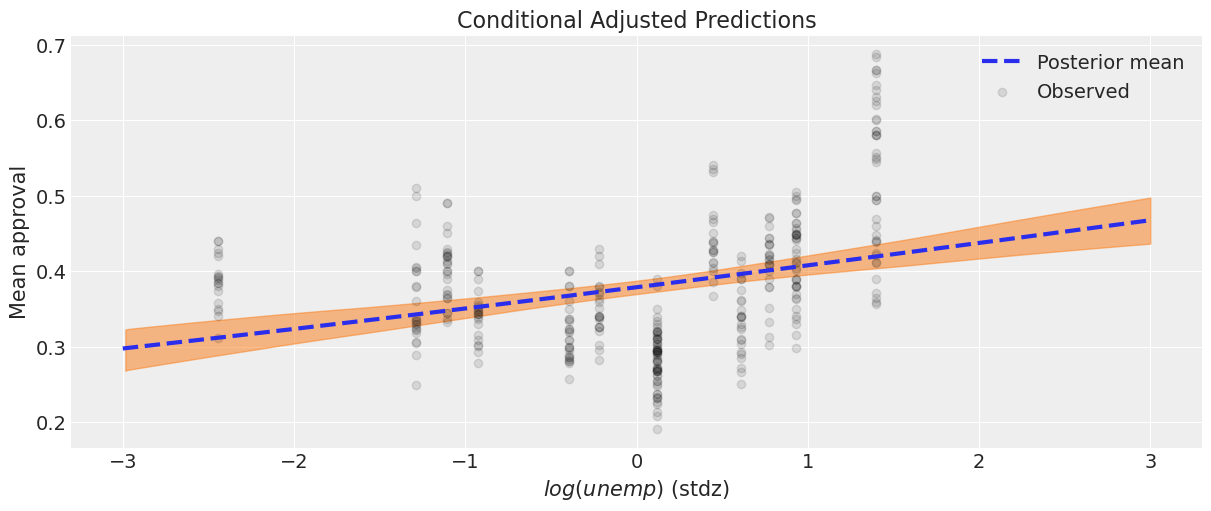

In [25]:
_, ax = plt.subplots(1, 1, figsize=(12, 5))

az.plot_hdi(fake_unemp, post_approval, ax=ax, backend_kwargs={"label": "Posterior HDI"})
ax.plot(fake_unemp, post_approval.mean(("chain", "draw")), ls="--", lw="3", label="Posterior mean")
ax.scatter(stdz_log_unemployment, polls["N_approve"] / polls["N_total"], c="k", alpha=0.1, label="Observed")

ax.set(xlabel="$log(unemp)$ (stdz)", ylabel="Mean approval", title="Conditional Adjusted Predictions")
ax.legend();

In [247]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Oct 23 2023

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

daft      : 0.1.2
arviz     : 0.16.1
numpy     : 1.24.4
bambi     : 0.13.0.dev0
seaborn   : 0.12.2
scipy     : 1.11.1
matplotlib: 3.7.2
pymc      : 5.9.0
xarray    : 2023.7.0
pandas    : 2.0.3

Watermark: 2.4.3

